In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [25]:
df = pd.read_csv("cleaned_dataset.csv")

In [26]:
df.head()

,image_path,Midline_Shift,Surgery_Advisable,processed_image_path,Has_Shift,Midline_Shift_Label
0,images/1.jpg,NaN,1,processed_images/1.jpg,0,2
1,images/2.jpg,NaN,0,processed_images/2.jpg,0,2
2,images/3.jpg,NaN,0,processed_images/3.jpg,0,2
3,images/4.jpg,Right,1,processed_images/4.jpg,1,1
4,images/5.jpg,NaN,0,processed_images/5.jpg,0,2


In [29]:
df.Has_Shift.value_counts()

Has_Shift
1    621
0    365
Name: count, dtype: int64

In [30]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['processed_image_path']
        label = self.df.iloc[idx]['Has_Shift']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)


In [31]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Has_Shift'], random_state=42)

In [32]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [33]:
class_counts = df['Has_Shift'].value_counts().to_dict()
class_weights = [1.0 / class_counts[label] for label in df['Has_Shift']]

train_dataset = BrainDataset(train_df, transform=train_transform)
test_dataset = BrainDataset(test_df, transform=test_transform)

sample_weights = [class_weights[label] for label in train_df['Has_Shift']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [34]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # binary classification

model = model.to(device)


In [35]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [36]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.5227
Epoch [2/10], Loss: 0.3476
Epoch [3/10], Loss: 0.3128
Epoch [4/10], Loss: 0.2398
Epoch [5/10], Loss: 0.2137
Epoch [6/10], Loss: 0.1624
Epoch [7/10], Loss: 0.1202
Epoch [8/10], Loss: 0.1054
Epoch [9/10], Loss: 0.1060
Epoch [10/10], Loss: 0.1047


Accuracy : 0.8030
Precision: 0.8359
Recall   : 0.8560
F1 Score : 0.8458

Classification Report:

              precision    recall  f1-score   support

    No Shift       0.74      0.71      0.73        73
       Shift       0.84      0.86      0.85       125

    accuracy                           0.80       198
   macro avg       0.79      0.78      0.79       198
weighted avg       0.80      0.80      0.80       198



/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_16097/423608525.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = [int(x) for x in y_true]
/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_16097/423608525.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x) for x in y_pred]


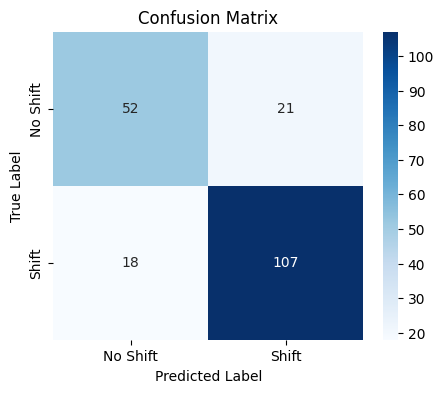

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to flat lists
y_true = [int(x) for x in y_true]
y_pred = [int(x) for x in y_pred]

# ✅ Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Shift", "Shift"]))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Shift", "Shift"], 
            yticklabels=["No Shift", "Shift"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
torch.save(model.state_dict(), "midlineshift_presence_resnet18.ipynb")